#Import Libraries

In [26]:
#Uncomment the below line to install torchbearer
#!pip install torchbearer
import torch
import torchbearer
import numpy as np
from torch import optim
from torchbearer import Trial

In [27]:
#Code for ASGD Optimizer has been ported from https://github.com/rahulkidambi/AccSGD/blob/master/AccSGD.py

from torch.optim.optimizer import Optimizer, required
import copy

class AccSGD(Optimizer):
    r"""Implements the algorithm proposed in https://arxiv.org/pdf/1704.08227.pdf, which is a provably accelerated method 
    for stochastic optimization. This has been employed in https://openreview.net/forum?id=rJTutzbA- for training several 
    deep learning models of practical interest. This code has been implemented by building on the construction of the SGD 
    optimization module found in pytorch codebase.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate (required)
        kappa (float, optional): ratio of long to short step (default: 1000)
        xi (float, optional): statistical advantage parameter (default: 10)
        smallConst (float, optional): any value <=1 (default: 0.7)
    Example:
        >>> from AccSGD import *
        >>> optimizer = AccSGD(model.parameters(), lr=0.1, kappa = 1000.0, xi = 10.0)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=0.001, kappa = 1000.0, xi = 10.0, smallConst = 0.7, weight_decay=0):
        defaults = dict(lr=lr, kappa=kappa, xi=xi, smallConst=smallConst,
                        weight_decay=weight_decay)
        super(AccSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AccSGD, self).__setstate__(state)

    def step(self, closure=None):
        """ Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            large_lr = (group['lr']*group['kappa'])/(group['smallConst'])
            Alpha = 1.0 - ((group['smallConst']*group['smallConst']*group['xi'])/group['kappa'])
            Beta = 1.0 - Alpha
            zeta = group['smallConst']/(group['smallConst']+Beta)
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = copy.deepcopy(p.data)
                buf = param_state['momentum_buffer']
                buf.mul_((1.0/Beta)-1.0)
                buf.add_(-large_lr,d_p)
                buf.add_(p.data)
                buf.mul_(Beta)

                p.data.add_(-group['lr'],d_p)
                p.data.mul_(zeta)
                p.data.add_(1.0-zeta,buf)

        return loss

#Prepare Data and Model Architecture for Training


#Download CIFAR10 Dataset

In [28]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

num_classes = 10

mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

#Perform Data augmentation to make robust models without requiring larger dataset, using Randomly Flipping the Image Horizontally and Randomly Cropping the Image
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), transforms.ToTensor(),transforms.Normalize(mean, std)])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

#Download and Transform the datasets
train_data = datasets.CIFAR10(root=".", train=True,  download=True, transform=train_transform)
test_data = datasets.CIFAR10(root=".", train=False, download=True, transform=test_transform)
valid_data = datasets.CIFAR10(root=".", train=True, download=True, transform=train_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


##Split Data into Train and Validation Sets

In [29]:
from torch.utils.data.sampler import SubsetRandomSampler

#Split Train Data into Train and Validation Data
#Desired ratio of split into Validation and Train Set
ratio = 0.2
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(ratio * num_train))

np.random.seed(7)
np.random.shuffle(indices)
batch_size = 8

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#Create Mini Batches for Train, Validation and Test Datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler, pin_memory=True)

In [30]:
print("Count of Train MiniBatches: ", len(train_loader))
print("Count of Validation MiniBatches: ", len(valid_loader))
print("Ratio of Count of Validation to Total Minibatches: ",len(valid_loader)/(len(valid_loader) + len(train_loader)))
print("Ratio of Count of Train to Total Minibatches: ",len(train_loader)/(len(valid_loader) + len(train_loader)))

Count of Train MiniBatches:  5000
Count of Validation MiniBatches:  1250
Ratio of Count of Validation to Total Minibatches:  0.2
Ratio of Count of Train to Total Minibatches:  0.8


##Create Resnet44 Architecture

In [31]:
#Resnet Architecture ported from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py and along the lines of https://arxiv.org/abs/1512.03385

import torch.nn as nn

class DownsampleCIFAR(nn.Module):  

  def __init__(self, nIn, nOut, stride):
    super(DownsampleCIFAR, self).__init__() 
    assert stride == 2    
    self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)   

  def forward(self, x):   
    x = self.avg(x)  
    return torch.cat((x, x.mul(0)), 1)  

class ResnetBlock(nn.Module):

  expansion = 1
  def __init__(self, inplanes, planes, stride, downsample, Type):
    super(ResnetBlock, self).__init__()

    self.Type = Type

    self.norm1 = nn.BatchNorm2d(inplanes)
    self.conv_a = nn.Conv2d(inplanes, planes, 3, stride, padding = 1, bias = False)

    self.norm2 = nn.BatchNorm2d(planes)
    self.conv_b = nn.Conv2d(planes, planes, 3, stride = 1, padding = 1, bias = False)

    self.relu = nn.ReLU(inplace = True)
    self.downsample = downsample

  
  def forward(self, x):
    initial = x

    block = self.norm1(x)
    block = self.relu(x)

    if self.Type == 'both_preact':
      initial = block

    block = self.conv_a(block)
    block = self.norm2(block)
    block = self.relu(block)
    block = self.conv_b(block)

    if self.downsample is not None:
     initial = self.downsample(initial)

    return initial + block


class Resnet(nn.Module):

  def __init__(self, block, depth, num_classes):

    super(Resnet, self).__init__()

    self.num_classes = num_classes

    layer_blocks = (depth-2)//6

    self.conv = nn.Conv2d(3, 16, 3, 1, padding=1, bias = False)

    self.inplanes = 16
    self.conv1 = self.make_layer(block, 16, layer_blocks, 1)
    self.conv2 = self.make_layer(block, 32, layer_blocks, 2)
    self.conv3 = self.make_layer(block, 64, layer_blocks, 2)
    self.final_activation = nn.Sequential(nn.BatchNorm2d(64*block.expansion), nn.ReLU(inplace=True))
    self.avgpool = nn.AvgPool2d(8)
    self.classifier = nn.Linear(64*block.expansion, num_classes)
  
  def make_layer(self, block, planes, blocks, stride = 1):
    downsample = None

    if (stride != 1 or self.inplanes != planes*block.expansion):
      downsample = DownsampleCIFAR(self.inplanes, planes*block.expansion, stride)

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, 'both_preact'))
    self.inplanes = planes*block.expansion
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes, 1, None, 'normal'))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.final_activation(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)


#Decayed Hyperparameter Schedule

##SGD

In [38]:
def decayed_stats_SGD(lr, decay, epochs, change):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_SGD = np.zeros(epochs)
  train_accuracy_SGD = np.zeros(epochs)
  valid_loss_SGD = np.zeros(epochs)
  valid_accuracy_SGD = np.zeros(epochs)
  test_accuracy_SGD = np.zeros(epochs)
  test_loss_SGD = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  #Initilise validation set error as criteria at change point
  error = 100
  prev_error = 100

  for epoch in range(epochs):

    #Creates a deep copy of the parameter and gradient tensors and makes them shareable to enable re-use of Resnet modules multiple times
    model = copy.deepcopy(model)
    optimiser = optim.SGD(model.parameters(), lr = lr, weight_decay=0.0005)
    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation error reduced by more than 1% or not
    if epoch%change == 0:
      if ((prev_error-error)/prev_error < 0.01) and epoch!=0:
        
        if lr/decay < 0.0000625:
         lr = 0.0000625
        else:
            lr=lr/decay

      else:
          lr=lr

      prev_error = error

    #Compute the metrics on Test Dataset
    test_metric = trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_SGD[epoch] = result[0]['loss']
    train_accuracy_SGD[epoch] = result[0]['acc']
    valid_loss_SGD[epoch] = result[0]['val_loss']
    valid_accuracy_SGD[epoch] = result[0]['val_acc']
    test_accuracy_SGD[epoch] = result[0]['test_acc']
    test_loss_SGD[epoch] = result[0]['test_loss']

    error = 1 - result[0]['val_acc']

    print(epoch, lr, result)

  return lr, train_loss_SGD, train_accuracy_SGD, valid_loss_SGD, valid_accuracy_SGD, test_loss_SGD, test_accuracy_SGD

  


In [ ]:
final_lr_SGD, train_loss_SGD, train_accuracy_SGD, valid_loss_SGD, valid_accuracy_SGD, test_loss_SGD, test_accuracy_SGD = decayed_stats_SGD(0.01, 5, 20, 3)

0 0.033 [{'running_loss': 1.3758032321929932, 'running_acc': 0.5074999928474426, 'loss': 1.6697766780853271, 'acc': 0.3806999921798706, 'val_loss': 1.2840301990509033, 'val_acc': 0.5358999967575073, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 1.2559431791305542, 'test_acc': 0.5381999611854553}]
1 0.033 [{'running_loss': 1.0719763040542603, 'running_acc': 0.5874999761581421, 'loss': 1.2202094793319702, 'acc': 0.5644499659538269, 'val_loss': 1.0344644784927368, 'val_acc': 0.6373999714851379, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 0.9735557436943054, 'test_acc': 0.6597999930381775}]
2 0.033 [{'running_loss': 0.9154149293899536, 'running_acc': 0.6775000095367432, 'loss': 1.0003331899642944, 'acc': 0.6531749963760376, 'val_loss': 1.0442771911621094, 'val_acc': 0.6395999789237976, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 1.0464640855789185, 'test_acc': 0.6428999900817871}]
3 0.033 [{'running_loss': 0.8318360447883606, 'running_acc': 0.7

###Load Precomputed Metrics

In [32]:
# # Uncomment the below lines to restore the pre computed metrics for SGD on Batch Size 8 and Decayed Hyperparameter Schedule

# final_lr_SGD = 0.01
# train_loss_SGD = np.array([1.74049413, 1.32672071, 1.13034368, 0.99976659, 0.89558858,
#        0.81559688, 0.74937862, 0.70619631, 0.65960217, 0.62637091,
#        0.59688038, 0.5735209 , 0.54874414, 0.5305056 , 0.50636828,
#        0.4897877 , 0.47212976, 0.45892313, 0.45019159, 0.44085321])
# train_accuracy_SGD = np.array([0.35402498, 0.53179997, 0.6049    , 0.65062499, 0.69072497,
#        0.72099996, 0.74614996, 0.76179999, 0.77689999, 0.78724998,
#        0.79947495, 0.80619997, 0.81535   , 0.820225  , 0.83015001,
#        0.83517498, 0.8416    , 0.84529996, 0.84779996, 0.85049999])
# valid_loss_SGD = np.array([1.56016028, 1.12439167, 1.08005238, 0.84790164, 0.80270326,
#        0.71018088, 0.69935906, 0.64984971, 0.67552048, 0.63846672,
#        0.58391827, 0.64078027, 0.59404677, 0.56540722, 0.55567014,
#        0.52006042, 0.5459255 , 0.53123826, 0.49333715, 0.5129174 ])
# valid_accuracy_SGD = np.array([0.42829999, 0.60139996, 0.61909997, 0.69889998, 0.71859998,
#        0.75749999, 0.76089996, 0.77609998, 0.76269996, 0.77919996,
#        0.79909998, 0.78009999, 0.79710001, 0.80680001, 0.81209999,
#        0.82440001, 0.81729996, 0.82239997, 0.83629996, 0.82389998])
# test_loss_SGD = np.array([1.53054953, 1.0633769 , 1.04497325, 0.81752396, 0.77344853,
#        0.67470473, 0.67539048, 0.6091345 , 0.64867938, 0.63710093,
#        0.57226866, 0.67314076, 0.56828457, 0.5531289 , 0.55596191,
#        0.50270659, 0.50844365, 0.54118681, 0.47233084, 0.48605791])
# test_accuracy_SGD = np.array([0.45089999, 0.6153    , 0.63119996, 0.71669996, 0.73939997,
#        0.77019995, 0.77319998, 0.79350001, 0.77999997, 0.78539997,
#        0.81169999, 0.7784    , 0.80579996, 0.8179    , 0.81819999,
#        0.83029997, 0.82949996, 0.82409996, 0.8427    , 0.83709997])

In [33]:
print("Final Learning Rate reached at the end of training: ", final_lr_SGD)
print("Training Loss Set: ", repr(train_loss_SGD))
print("Training Accuracy Set: ",repr(train_accuracy_SGD))
print("Validation Loss Set: ", repr(valid_loss_SGD))
print("Validation Accuracy Set: ",repr(valid_accuracy_SGD))
print("Test Loss Set: ", repr(test_loss_SGD))
print("Test Accuracy Set: ",repr(test_accuracy_SGD))

Final Learning Rate reached at the end of training:  0.01
Training Loss Set:  array([1.74049413, 1.32672071, 1.13034368, 0.99976659, 0.89558858,
       0.81559688, 0.74937862, 0.70619631, 0.65960217, 0.62637091,
       0.59688038, 0.5735209 , 0.54874414, 0.5305056 , 0.50636828,
       0.4897877 , 0.47212976, 0.45892313, 0.45019159, 0.44085321])
Training Accuracy Set:  array([0.35402498, 0.53179997, 0.6049    , 0.65062499, 0.69072497,
       0.72099996, 0.74614996, 0.76179999, 0.77689999, 0.78724998,
       0.79947495, 0.80619997, 0.81535   , 0.820225  , 0.83015001,
       0.83517498, 0.8416    , 0.84529996, 0.84779996, 0.85049999])
Validation Loss Set:  array([1.56016028, 1.12439167, 1.08005238, 0.84790164, 0.80270326,
       0.71018088, 0.69935906, 0.64984971, 0.67552048, 0.63846672,
       0.58391827, 0.64078027, 0.59404677, 0.56540722, 0.55567014,
       0.52006042, 0.5459255 , 0.53123826, 0.49333715, 0.5129174 ])
Validation Accuracy Set:  array([0.42829999, 0.60139996, 0.61909997, 

##Heavy Ball

In [41]:
def decayed_stats_HeavyBall(lr, momentum, decay, epochs, change):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_HeavyBall = np.zeros(epochs)
  train_accuracy_HeavyBall = np.zeros(epochs)
  valid_loss_HeavyBall = np.zeros(epochs)
  valid_accuracy_HeavyBall = np.zeros(epochs)
  test_accuracy_HeavyBall = np.zeros(epochs)
  test_loss_HeavyBall = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  #Initilise validation set error as criteria at change point
  error = 100
  prev_error = 100

  for epoch in range(epochs):

    #Creates a deep copy of the parameter and gradient tensors and makes them shareable to enable re-use of Resnet modules multiple times
    model = copy.deepcopy(model)
    optimiser = optim.SGD(model.parameters(), lr = lr, momentum = momentum, weight_decay=0.0005)
    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'],  verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation error reduced by more than 1% or not
    if epoch%change == 0:
      if ((prev_error-error)/prev_error < 0.01)  and epoch!=0:
        
        if lr/decay < 0.0000625:
         lr = 0.0000625
        else:
            lr=lr/decay

      else:
          lr=lr

      prev_error = error

    #Compute the metrics on Test Dataset
    trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_HeavyBall[epoch] = result[0]['loss']
    train_accuracy_HeavyBall[epoch] = result[0]['acc']
    valid_loss_HeavyBall[epoch] = result[0]['val_loss']
    valid_accuracy_HeavyBall[epoch] = result[0]['val_acc']
    test_accuracy_HeavyBall[epoch] = result[0]['test_acc']
    test_loss_HeavyBall[epoch] = result[0]['test_loss']

    error = 1 - result[0]['val_acc']

    print(epoch, lr, momentum, result)
      
  return lr, train_loss_HeavyBall, train_accuracy_HeavyBall, valid_loss_HeavyBall, valid_accuracy_HeavyBall, test_loss_HeavyBall, test_accuracy_HeavyBall
    


In [43]:
final_lr_HeavyBall, train_loss_HeavyBall, train_accuracy_HeavyBall, valid_loss_HeavyBall, valid_accuracy_HeavyBall, test_loss_HeavyBall, test_accuracy_HeavyBall = decayed_stats_HeavyBall(0.01, 0.8, 5, 20, 3)

0 0.033 0.8 [{'running_loss': 1.3558720350265503, 'running_acc': 0.4749999940395355, 'loss': 1.6785290241241455, 'acc': 0.38165000081062317, 'val_loss': 1.3893768787384033, 'val_acc': 0.495199978351593, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 1.3275483846664429, 'test_acc': 0.5180000066757202}]
1 0.033 0.8 [{'running_loss': 1.1386094093322754, 'running_acc': 0.612500011920929, 'loss': 1.2373193502426147, 'acc': 0.56107497215271, 'val_loss': 1.0400121212005615, 'val_acc': 0.6381999850273132, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 0.9865331053733826, 'test_acc': 0.652999997138977}]
2 0.033 0.8 [{'running_loss': 0.9851047396659851, 'running_acc': 0.675000011920929, 'loss': 1.0433870553970337, 'acc': 0.6370999813079834, 'val_loss': 1.012121319770813, 'val_acc': 0.6500999927520752, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 0.9847530126571655, 'test_acc': 0.6649999618530273}]
3 0.033 0.8 [{'running_loss': 0.9640704393386841, 'running

###Load Precomputed Metrics

In [34]:
# Uncomment the below lines to restore the pre computed metrics for Heavy Ball on Batch Size 8 and Decayed Hyperparameter Schedule

# final_lr_HeavyBall = 0.002
# train_loss_HeavyBall = np.array([1.66774094, 1.24852133, 1.0471195 , 0.91592354, 0.82082087,
#        0.74844289, 0.70885819, 0.6736992 , 0.64598846, 0.61945122,
#        0.60606438, 0.58594513, 0.57488233, 0.42195585, 0.3832303 ,
#        0.36717811, 0.35257769, 0.34855446, 0.33960181, 0.32915324])
# train_accuracy_HeavyBall = np.array([0.38395   , 0.55577499, 0.63244998, 0.68232501, 0.71669996,
#        0.74307495, 0.75957501, 0.77109998, 0.782175  , 0.79087496,
#        0.79444999, 0.80032498, 0.80619997, 0.85677499, 0.87049997,
#        0.87647498, 0.88249999, 0.88249999, 0.88575   , 0.889     ])
# valid_loss_HeavyBall = np.array([1.42731965, 1.10787272, 1.05332899, 0.85534352, 0.7891888 ,
#        0.79466641, 0.70659292, 0.76722836, 0.60918164, 0.59098113,
#        0.58385986, 0.61728853, 0.62941593, 0.41651708, 0.42061454,
#        0.39832652, 0.39219046, 0.41460711, 0.40510291, 0.38520691])
# valid_accuracy_HeavyBall = np.array([0.4777    , 0.60869998, 0.6243    , 0.70929998, 0.72719997,
#        0.72889996, 0.7525    , 0.7457    , 0.78959996, 0.8028    ,
#        0.79869998, 0.78929996, 0.78009999, 0.85819995, 0.85789996,
#        0.86519998, 0.8653    , 0.8624    , 0.86309999, 0.86829996])
# test_loss_HeavyBall = np.array([1.36539793, 1.03675103, 1.03521919, 0.85099   , 0.73918033,
#        0.78422374, 0.68224454, 0.71730119, 0.59205103, 0.55135512,
#        0.57191551, 0.61436087, 0.62529236, 0.38439932, 0.39530611,
#        0.38241714, 0.37043849, 0.41040561, 0.39014727, 0.37429655])
# test_accuracy_HeavyBall = np.array([0.50589997, 0.63069999, 0.64109999, 0.71919996, 0.74589998,
#        0.7335    , 0.76749998, 0.76209998, 0.79749995, 0.81049997,
#        0.80909997, 0.79179996, 0.79109997, 0.86869997, 0.86919999,
#        0.87      , 0.87509996, 0.86799997, 0.86750001, 0.8732    ])

In [35]:
print("Final Learning Rate reached at the end of training: ", final_lr_HeavyBall)
print("Training Loss Set: ",repr(train_loss_HeavyBall))
print("Training Accuracy Set: ",repr(train_accuracy_HeavyBall))
print("Validation Loss Set: ", repr(valid_loss_HeavyBall))
print("Validation Accuracy Set: ",repr(valid_accuracy_HeavyBall))
print("Test Loss Set: ", repr(test_loss_HeavyBall))
print("Test Accuracy Set: ",repr(test_accuracy_HeavyBall))

Final Learning Rate reached at the end of training:  0.002
Training Loss Set:  array([1.66774094, 1.24852133, 1.0471195 , 0.91592354, 0.82082087,
       0.74844289, 0.70885819, 0.6736992 , 0.64598846, 0.61945122,
       0.60606438, 0.58594513, 0.57488233, 0.42195585, 0.3832303 ,
       0.36717811, 0.35257769, 0.34855446, 0.33960181, 0.32915324])
Training Accuracy Set:  array([0.38395   , 0.55577499, 0.63244998, 0.68232501, 0.71669996,
       0.74307495, 0.75957501, 0.77109998, 0.782175  , 0.79087496,
       0.79444999, 0.80032498, 0.80619997, 0.85677499, 0.87049997,
       0.87647498, 0.88249999, 0.88249999, 0.88575   , 0.889     ])
Validation Loss Set:  array([1.42731965, 1.10787272, 1.05332899, 0.85534352, 0.7891888 ,
       0.79466641, 0.70659292, 0.76722836, 0.60918164, 0.59098113,
       0.58385986, 0.61728853, 0.62941593, 0.41651708, 0.42061454,
       0.39832652, 0.39219046, 0.41460711, 0.40510291, 0.38520691])
Validation Accuracy Set:  array([0.4777    , 0.60869998, 0.6243    ,

##NAG

In [ ]:
def decayed_stats_NAG(lr, momentum, decay, epochs, change):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_NAG = np.zeros(epochs)
  train_accuracy_NAG = np.zeros(epochs)
  valid_loss_NAG = np.zeros(epochs)
  valid_accuracy_NAG = np.zeros(epochs)
  test_accuracy_NAG = np.zeros(epochs)
  test_loss_NAG = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  #Initilise validation set error as criteria at change point
  error = 100
  prev_error = 100

  for epoch in range(epochs):
      #Creates a deep copy of the parameter and gradient tensors and makes them shareable to enable re-use of Resnet modules multiple times
      model = copy.deepcopy(model)
      optimiser = optim.SGD(model.parameters(), lr = lr, momentum = momentum, nesterov = True, weight_decay=0.0005)
      #Train the model on training data
      trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'],  verbose=0).to(device)
      trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

      result = trial.run(epochs=1)

      #At change points, update the hyperparameters depending on whether validation error reduced by more than 1% or not
      if epoch%change == 0:
        if ((prev_error-error)/prev_error < 0.01) and epoch!=0:

          if lr/decay < 0.0000625:
            lr = 0.0000625
          else:
              lr=lr/decay

        else:
            lr=lr
        prev_error = error

      #Compute the metrics on Test Dataset
      trial.evaluate(data_key=torchbearer.TEST_DATA)

      #Store the metrics at each epoch
      train_loss_NAG[epoch] = result[0]['loss']
      train_accuracy_NAG[epoch] = result[0]['acc']
      valid_loss_NAG[epoch] = result[0]['val_loss']
      valid_accuracy_NAG[epoch] = result[0]['val_acc']
      test_accuracy_NAG[epoch] = result[0]['test_acc']
      test_loss_NAG[epoch] = result[0]['test_loss']

      error = 1 - result[0]['val_acc']

      print(epoch, lr, momentum, result)

  return lr, train_loss_NAG, train_accuracy_NAG, valid_loss_NAG, valid_accuracy_NAG, test_loss_NAG, test_accuracy_NAG


In [ ]:
final_lr_NAG, train_loss_NAG, train_accuracy_NAG, valid_loss_NAG, valid_accuracy_NAG, test_loss_NAG, test_accuracy_NAG = decayed_stats_NAG(0.033, 0.8, 5, 20, 3) 

0 0.033 0.8 [{'running_loss': 1.5053421258926392, 'running_acc': 0.48749998211860657, 'loss': 1.693831205368042, 'acc': 0.37629997730255127, 'val_loss': 1.352144718170166, 'val_acc': 0.5105999708175659, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 1.287845492362976, 'test_acc': 0.5288000106811523}]
1 0.033 0.8 [{'running_loss': 1.0610105991363525, 'running_acc': 0.6399999856948853, 'loss': 1.262020468711853, 'acc': 0.5512750148773193, 'val_loss': 1.1215133666992188, 'val_acc': 0.614300012588501, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 1.11811363697052, 'test_acc': 0.6245999932289124}]
2 0.033 0.8 [{'running_loss': 0.9313132166862488, 'running_acc': 0.6899999976158142, 'loss': 1.0453234910964966, 'acc': 0.6373999714851379, 'val_loss': 0.985342264175415, 'val_acc': 0.6584999561309814, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 0.951274573802948, 'test_acc': 0.6812999844551086}]
3 0.0066 0.8 [{'running_loss': 1.0141831636428833, 'running

###Load Precomputed Metrics

In [36]:
# # Uncomment the below lines to restore the pre computed metrics for NAG on Batch Size 8 and Decayed Hyperparameter Schedule

# final_lr_NAG = .0033
# train_loss_NAG = np.array([1.71988809, 1.29914308, 1.07954776, 0.95561814, 0.89137459,
#        0.85426939, 0.82173175, 0.79783243, 0.77668649, 0.76683259,
#        0.75529331, 0.74070221, 0.73360246, 0.51124501, 0.45259282,
#        0.42656377, 0.40407449, 0.39001095, 0.38238779, 0.37184608])
# train_accuracy_NAG = np.array([0.35834998, 0.537925  , 0.62317497, 0.66729999, 0.691625  ,
#        0.70699996, 0.71794999, 0.72767496, 0.73677498, 0.74077499,
#        0.74245   , 0.74664998, 0.75169998, 0.82907498, 0.848575  ,
#        0.85729998, 0.86429995, 0.86930001, 0.87077498, 0.87649995])
# valid_loss_NAG = np.array([1.40929306, 1.09356678, 1.00825012, 1.06190968, 0.97852695,
#        0.93381196, 0.8317579 , 0.86246735, 0.81682891, 0.83787596,
#        0.88332832, 0.86016071, 0.9166652 , 0.46296313, 0.43751311,
#        0.42873579, 0.42966861, 0.41955474, 0.41579834, 0.42130855])
# valid_accuracy_NAG = np.array([0.4813    , 0.61739999, 0.65179998, 0.64429998, 0.67329997,
#        0.67750001, 0.71069998, 0.69549996, 0.71819997, 0.72240001,
#        0.69220001, 0.7015    , 0.68949997, 0.84389997, 0.85099995,
#        0.8524    , 0.85469997, 0.85929996, 0.85619998, 0.85829997])
# test_loss_NAG = np.array([1.37963986, 1.05978191, 0.95696777, 1.02892053, 0.87554801,
#        0.95222896, 0.788822  , 0.81178492, 0.76654345, 0.81213814,
#        0.89421445, 0.91007334, 0.93985689, 0.43652412, 0.41092786,
#        0.40698892, 0.40439937, 0.40077454, 0.38929331, 0.40102407])
# test_accuracy_NAG = np.array([0.4928    , 0.62279999, 0.67519999, 0.65380001, 0.71139997,
#        0.67919999, 0.72459996, 0.71289998, 0.7414    , 0.73939997,
#        0.699     , 0.6972    , 0.6893    , 0.8567    , 0.86210001,
#        0.86359996, 0.86509997, 0.86499995, 0.86549997, 0.8664    ])


In [37]:
print("Final Learning Rate reached at the end of training: ", final_lr_NAG)
print("Training Loss Set: ",repr(train_loss_NAG))
print("Training Accuracy Set: ",repr(train_accuracy_NAG))
print("Validation Loss Set: ", repr(valid_loss_NAG))
print("Validation Accuracy Set: ",repr(valid_accuracy_NAG))
print("Test Loss Set: ", repr(test_loss_NAG))
print("Test Accuracy Set: ",repr(test_accuracy_NAG))

Final Learning Rate reached at the end of training:  0.0033
Training Loss Set:  array([1.71988809, 1.29914308, 1.07954776, 0.95561814, 0.89137459,
       0.85426939, 0.82173175, 0.79783243, 0.77668649, 0.76683259,
       0.75529331, 0.74070221, 0.73360246, 0.51124501, 0.45259282,
       0.42656377, 0.40407449, 0.39001095, 0.38238779, 0.37184608])
Training Accuracy Set:  array([0.35834998, 0.537925  , 0.62317497, 0.66729999, 0.691625  ,
       0.70699996, 0.71794999, 0.72767496, 0.73677498, 0.74077499,
       0.74245   , 0.74664998, 0.75169998, 0.82907498, 0.848575  ,
       0.85729998, 0.86429995, 0.86930001, 0.87077498, 0.87649995])
Validation Loss Set:  array([1.40929306, 1.09356678, 1.00825012, 1.06190968, 0.97852695,
       0.93381196, 0.8317579 , 0.86246735, 0.81682891, 0.83787596,
       0.88332832, 0.86016071, 0.9166652 , 0.46296313, 0.43751311,
       0.42873579, 0.42966861, 0.41955474, 0.41579834, 0.42130855])
Validation Accuracy Set:  array([0.4813    , 0.61739999, 0.65179998

##ASGD

In [45]:
def decayed_stats_ASGD(lr, decay, epochs, change, kappa=10000, xi=5):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_ASGD = np.zeros(epochs)
  train_accuracy_ASGD = np.zeros(epochs)
  valid_loss_ASGD = np.zeros(epochs)
  valid_accuracy_ASGD = np.zeros(epochs)
  test_accuracy_ASGD = np.zeros(epochs)
  test_loss_ASGD = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  #Initilise validation set error as criteria at change point
  error = 100
  prev_error = 100

  for epoch in range(epochs):

    #Creates a deep copy of the parameter and gradient tensors and makes them shareable to enable re-use of Resnet modules multiple times
    model = copy.deepcopy(model)
    optimiser = AccSGD(model.parameters(),  lr = lr, kappa=kappa, xi=xi,weight_decay=0.0005)
    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation error reduced by more than 1% or not
    if epoch%change == 0:
      if ((prev_error-error)/prev_error < 0.01) and epoch!=0:
        
        if lr/decay < 0.0000625:
         lr = 0.0000625
        else:
            lr=lr/decay

      else:
          lr=lr

      prev_error = error

    #Compute the metrics on Test Dataset
    test_metric = trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_ASGD[epoch] = result[0]['loss']
    train_accuracy_ASGD[epoch] = result[0]['acc']
    valid_loss_ASGD[epoch] = result[0]['val_loss']
    valid_accuracy_ASGD[epoch] = result[0]['val_acc']
    test_accuracy_ASGD[epoch] = test_metric['test_acc']
    test_loss_ASGD[epoch] = test_metric['test_loss']

    error = 1 - result[0]['val_acc']

    print(epoch, lr, result)

  return lr, train_loss_ASGD, train_accuracy_ASGD, valid_loss_ASGD, valid_accuracy_ASGD, test_accuracy_ASGD, test_loss_ASGD

In [46]:
 final_lr_ASGD, train_loss_ASGD, train_accuracy_ASGD, valid_loss_ASGD, valid_accuracy_ASGD, test_accuracy_ASGD, test_loss_ASGD = decayed_stats_ASGD(0.01, 5, 20, 3, kappa=1000, xi=5)


0 0.033 [{'running_loss': 1.3096946477890015, 'running_acc': 0.5324999690055847, 'loss': 1.625281572341919, 'acc': 0.40059998631477356, 'val_loss': 1.263443946838379, 'val_acc': 0.5396999716758728, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 1.2329131364822388, 'test_acc': 0.5476999878883362}]
1 0.033 [{'running_loss': 0.9788863658905029, 'running_acc': 0.6875, 'loss': 1.161270022392273, 'acc': 0.5908499956130981, 'val_loss': 1.0035169124603271, 'val_acc': 0.6459000110626221, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 0.978852391242981, 'test_acc': 0.6610999703407288}]
2 0.033 [{'running_loss': 0.9151138067245483, 'running_acc': 0.6899999976158142, 'loss': 0.9526777863502502, 'acc': 0.6712499856948853, 'val_loss': 0.9127427339553833, 'val_acc': 0.6812999844551086, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 0.8609089851379395, 'test_acc': 0.7046999931335449}]
3 0.033 [{'running_loss': 0.8199616074562073, 'running_acc': 0.7299999594688416

###Load Precomputed Metrics

In [39]:
# # Uncomment the below lines to restore the pre computed metrics for ASGD on Batch Size 8 and Decayed Hyperparameter Schedule

# final_lr_ASGD = 0.002
# train_loss_ASGD = np.array([1.58919132, 1.17473221, 0.96296453, 0.84262353, 0.76260924,
#        0.69223106, 0.64281523, 0.61255813, 0.57564855, 0.54999876,
#        0.53011119, 0.51083893, 0.4969238 , 0.4824703 , 0.46589959,
#        0.4574061 , 0.34007481, 0.30609426, 0.2900002 , 0.28160962])
# train_accuracy_ASGD = np.array([0.41927499, 0.58739996, 0.66877496, 0.712825  , 0.74147499,
#        0.76572496, 0.78424996, 0.79464996, 0.80664998, 0.81462497,
#        0.82379997, 0.82862496, 0.83437496, 0.83717495, 0.84377497,
#        0.8466    , 0.88617498, 0.8973    , 0.90274996, 0.90702498])
# valid_loss_ASGD = np.array([1.22578263, 1.01553273, 0.83578181, 0.75604945, 0.75199747,
#        0.65062433, 0.60330665, 0.57056803, 0.59517789, 0.563384  ,
#        0.55008548, 0.51637214, 0.49108344, 0.51067078, 0.52569926,
#        0.50501519, 0.38354635, 0.3668088 , 0.37753755, 0.36981937])
# valid_accuracy_ASGD = np.array([0.56059998, 0.64340001, 0.70419997, 0.7367    , 0.73879999,
#        0.78029996, 0.79269999, 0.80669999, 0.79829997, 0.81369996,
#        0.8125    , 0.82789999, 0.83709997, 0.82739997, 0.82019997,
#        0.82549995, 0.87129998, 0.87360001, 0.87259996, 0.87409997])
# test_loss_ASGD = np.array([1.17463982, 1.01082015, 0.79810256, 0.76910925, 0.72456241,
#        0.61660045, 0.58448511, 0.55800223, 0.59107107, 0.51671088,
#        0.52455586, 0.48659828, 0.46810967, 0.48155048, 0.53297049,
#        0.50216442, 0.37553626, 0.3569853 , 0.360899  , 0.35293877])
# test_accuracy_ASGD = np.array([0.57599998, 0.65380001, 0.71810001, 0.7353    , 0.74899995,
#        0.79799998, 0.79969996, 0.81209999, 0.80769998, 0.82709998,
#        0.82189995, 0.83289999, 0.84529996, 0.84219998, 0.82849997,
#        0.83559996, 0.87729996, 0.88099998, 0.87949997, 0.88049996])

In [40]:
print("Final Learning Rate reached at the end of training: ", final_lr_ASGD)
print("Training Loss Set: ", repr(train_loss_ASGD))
print("Training Accuracy Set: ",repr(train_accuracy_ASGD))
print("Validation Loss Set: ",repr(valid_loss_ASGD))
print("Validation Accuracy Set: ",repr(valid_accuracy_ASGD))
print("Test Loss Set: ",repr(test_loss_ASGD))
print("Test Accuracy Set: ",repr(test_accuracy_ASGD))


Final Learning Rate reached at the end of training:  0.002
Training Loss Set:  array([1.58919132, 1.17473221, 0.96296453, 0.84262353, 0.76260924,
       0.69223106, 0.64281523, 0.61255813, 0.57564855, 0.54999876,
       0.53011119, 0.51083893, 0.4969238 , 0.4824703 , 0.46589959,
       0.4574061 , 0.34007481, 0.30609426, 0.2900002 , 0.28160962])
Training Accuracy Set:  array([0.41927499, 0.58739996, 0.66877496, 0.712825  , 0.74147499,
       0.76572496, 0.78424996, 0.79464996, 0.80664998, 0.81462497,
       0.82379997, 0.82862496, 0.83437496, 0.83717495, 0.84377497,
       0.8466    , 0.88617498, 0.8973    , 0.90274996, 0.90702498])
Validation Loss Set:  array([1.22578263, 1.01553273, 0.83578181, 0.75604945, 0.75199747,
       0.65062433, 0.60330665, 0.57056803, 0.59517789, 0.563384  ,
       0.55008548, 0.51637214, 0.49108344, 0.51067078, 0.52569926,
       0.50501519, 0.38354635, 0.3668088 , 0.37753755, 0.36981937])
Validation Accuracy Set:  array([0.56059998, 0.64340001, 0.70419997,

##Adam

In [55]:
def decayed_stats_Adam(lr, decay, epochs, change):
      
  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_Adam = np.zeros(epochs)
  train_accuracy_Adam = np.zeros(epochs)
  valid_loss_Adam = np.zeros(epochs)
  valid_accuracy_Adam = np.zeros(epochs)
  test_accuracy_Adam = np.zeros(epochs)
  test_loss_Adam = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  #Initilise validation set error as criteria at change point
  error = 100
  prev_error = 100

  for epoch in range(epochs):

    #Creates a deep copy of the parameter and gradient tensors and makes them shareable to enable re-use of Resnet modules multiple times
    model = copy.deepcopy(model)
    optimiser = optim.Adam(model.parameters(),  lr = lr, weight_decay=0.0005)
    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation error reduced by more than 1% or not
    if epoch%change == 0:
      if ((prev_error-error)/prev_error < 0.01) and epoch!=0:
        
        if lr/decay < 0.0000625:
         lr = 0.0000625
        else:
            lr=lr/decay

      else:
          lr=lr

      prev_error = error

    test_metric = trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_Adam[epoch] = result[0]['loss']
    train_accuracy_Adam[epoch] = result[0]['acc']
    valid_loss_Adam[epoch] = result[0]['val_loss']
    valid_accuracy_Adam[epoch] = result[0]['val_acc']
    test_accuracy_Adam[epoch] = test_metric['test_acc']
    test_loss_Adam[epoch] = test_metric['test_loss']

    error = 1 - result[0]['val_acc']

    print(epoch, lr, result)

  return lr, train_loss_Adam, train_accuracy_Adam, valid_loss_Adam, valid_accuracy_Adam, test_accuracy_Adam, test_loss_Adam

In [ ]:
 final_lr_Adam, train_loss_Adam, train_accuracy_Adam, valid_loss_Adam, valid_accuracy_Adam, test_accuracy_Adam, test_loss_Adam = decayed_stats_Adam(0.001, 10, 20, 3)

0 0.001 [{'running_loss': 1.7021256685256958, 'running_acc': 0.35749998688697815, 'loss': 1.8114932775497437, 'acc': 0.3201499879360199, 'val_loss': 1.5653077363967896, 'val_acc': 0.42179998755455017, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 1.4803475141525269, 'test_acc': 0.4493999779224396}]
1 0.001 [{'running_loss': 1.2808071374893188, 'running_acc': 0.5525000095367432, 'loss': 1.4322797060012817, 'acc': 0.48399999737739563, 'val_loss': 1.229349970817566, 'val_acc': 0.5586000084877014, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 1.1722451448440552, 'test_acc': 0.5762999653816223}]
2 0.001 [{'running_loss': 1.0736936330795288, 'running_acc': 0.6150000095367432, 'loss': 1.181382656097412, 'acc': 0.5825999975204468, 'val_loss': 1.0542497634887695, 'val_acc': 0.617900013923645, 'train_steps': 5000, 'validation_steps': 1250, 'test_loss': 1.0361838340759277, 'test_acc': 0.6251999735832214}]
3 0.001 [{'running_loss': 0.9790947437286377, 'running_acc': 0.6

###Load Precomputed Metrics

In [41]:
# # Uncomment the below lines to restore the pre computed metrics for Adam on Batch Size 8 and Decayed Hyperparameter Schedule

# final_lr_Adam = 6.25e-05
# train_loss_Adam = np.array([1.82052827, 1.4499712 , 1.24283719, 1.10869968, 1.01592672,
#        0.93206149, 0.88295323, 0.83725876, 0.80472004, 0.78270024,
#        0.77774221, 0.75486284, 0.73781234, 0.6067698 , 0.56517899,
#        0.54753089, 0.53797686, 0.53021741, 0.52135974, 0.48152083])
# train_accuracy_Adam = np.array([0.31577498, 0.47744998, 0.56059998, 0.61079997, 0.64542496,
#        0.67764997, 0.69507498, 0.71597499, 0.72674996, 0.73379999,
#        0.73502499, 0.74217498, 0.75432497, 0.79522496, 0.81169999,
#        0.81742495, 0.81909996, 0.82042497, 0.824     , 0.83969998])
# valid_loss_Adam = np.array([1.53175294, 1.31268334, 1.15991521, 0.96513486, 0.86808366,
#        0.92742032, 0.78041536, 0.86087567, 0.72564769, 0.72201002,
#        0.87109911, 0.76123583, 0.72165751, 0.53766489, 0.53640848,
#        0.50912201, 0.50892013, 0.51304412, 0.49902821, 0.46797127])
# valid_accuracy_Adam = np.array([0.43699998, 0.52859998, 0.58239996, 0.6602    , 0.69870001,
#        0.67369998, 0.73609996, 0.69949996, 0.75400001, 0.75349998,
#        0.704     , 0.7421    , 0.75419998, 0.81869996, 0.8211    ,
#        0.82969999, 0.82749999, 0.82159996, 0.83139998, 0.84289998])
# test_loss_Adam = np.array([1.48973691, 1.21305323, 1.15768313, 0.92161822, 0.84630787,
#        0.94687754, 0.75437087, 0.84950215, 0.70269239, 0.69248849,
#        0.87529522, 0.74152589, 0.73194474, 0.52255052, 0.50944835,
#        0.4785229 , 0.47436488, 0.49250615, 0.46887699, 0.44359872])
# test_accuracy_Adam = np.array([0.44299999, 0.55809999, 0.58789998, 0.67399997, 0.70469999,
#        0.67249995, 0.7403    , 0.71169996, 0.76249999, 0.76559997,
#        0.70899999, 0.75059998, 0.7554    , 0.82069999, 0.8276    ,
#        0.83849996, 0.83999997, 0.83109999, 0.84209996, 0.84929997])

In [42]:
print("Final Learning Rate reached at the end of training: ", final_lr_Adam)
print("Training Loss Set: ", repr(train_loss_Adam))
print("Training Accuracy Set: ",repr(train_accuracy_Adam))
print("Validation Loss Set: ", repr(valid_loss_Adam))
print("Validation Accuracy Set: ",repr(valid_accuracy_Adam))
print("Test Loss Set: ", repr(test_loss_Adam))
print("Test Accuracy Set: ",repr(test_accuracy_Adam))

Final Learning Rate reached at the end of training:  6.25e-05
Training Loss Set:  array([1.82052827, 1.4499712 , 1.24283719, 1.10869968, 1.01592672,
       0.93206149, 0.88295323, 0.83725876, 0.80472004, 0.78270024,
       0.77774221, 0.75486284, 0.73781234, 0.6067698 , 0.56517899,
       0.54753089, 0.53797686, 0.53021741, 0.52135974, 0.48152083])
Training Accuracy Set:  array([0.31577498, 0.47744998, 0.56059998, 0.61079997, 0.64542496,
       0.67764997, 0.69507498, 0.71597499, 0.72674996, 0.73379999,
       0.73502499, 0.74217498, 0.75432497, 0.79522496, 0.81169999,
       0.81742495, 0.81909996, 0.82042497, 0.824     , 0.83969998])
Validation Loss Set:  array([1.53175294, 1.31268334, 1.15991521, 0.96513486, 0.86808366,
       0.92742032, 0.78041536, 0.86087567, 0.72564769, 0.72201002,
       0.87109911, 0.76123583, 0.72165751, 0.53766489, 0.53640848,
       0.50912201, 0.50892013, 0.51304412, 0.49902821, 0.46797127])
Validation Accuracy Set:  array([0.43699998, 0.52859998, 0.582399

##Plot

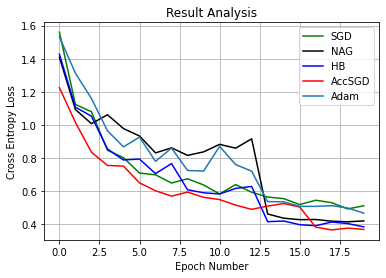

In [43]:
import matplotlib.pyplot as plt

#Create array of epochs for X axis
x_axis = np.zeros((20,1))
for i in range(20):
  x_axis[i] = i

#Plot Validation Loss for each algorithm
plt.title('Result Analysis')
plt.plot(x_axis, valid_loss_SGD, color='green', label='SGD')
plt.plot(x_axis, valid_loss_NAG, color='black', label='NAG')
plt.plot(x_axis, valid_loss_HeavyBall, color='blue', label='HB')
plt.plot(x_axis, valid_loss_ASGD, color='red', label='AccSGD')
plt.plot(x_axis, valid_loss_Adam, label='Adam')

plt.legend()
 
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy Loss')
plt.grid(axis='both')
plt.savefig('Resnet8_decayedrate_validloss.png')
plt.show()


In [44]:
from google.colab import files
files.download("Resnet8_decayedrate_validloss.png")

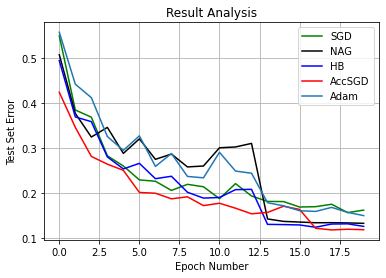

In [45]:
#Create array of epochs for X axis
x_axis = np.zeros((20,1))
for i in range(20):
  x_axis[i] = i

#Plot Test Error for each algorithm
plt.title('Result Analysis')
plt.plot(x_axis, 1-test_accuracy_SGD, color='green', label='SGD')
plt.plot(x_axis, 1-test_accuracy_NAG, color='black', label='NAG')
plt.plot(x_axis, 1-test_accuracy_HeavyBall, color='blue', label='HB')
plt.plot(x_axis, 1-test_accuracy_ASGD, color='red', label='AccSGD')
plt.plot(x_axis, 1-test_accuracy_Adam, label='Adam')

plt.legend()
 
plt.xlabel('Epoch Number')
plt.ylabel('Test Set Error')
plt.grid(axis='both')
plt.savefig('Resnet8_decayedrate_testerror.png')
plt.show()

In [22]:
files.download("Resnet8_decayedrate_testerror.png")